# Capstone Project - Choosing the Best Store Category

## Introduction/ Business Problem

The city of Toronto is always growing, implementing changes, and finding new ways to attract new people. There are tons of different varieties of stores from big malls to diverse ethnic dining. However, considering how diverse the type of stores is already in Toronto, how should a person hoping to open a store in Toronto approach this? If they want to open a restaurant, will they have too many competitions if its an Italian restaurant? What about Chinese restaurant? This is where Foursquare API will extremely useful since I can obtain information about the trending stores within Toronto. Since Toronto is quite large, I can break up Toronto into small clusters to analyze within a cluster what types of stores are more popular against others.

There are two ways of analyzing this problem. I can obtain more general analysis to see which type of stores are the most popular within each cluster and see if a type sticks out above others. Or I can examine a single cluster very closely to analyze the trend within the cluster and see what type of store can fit the trend better.

## Data Used

For the data, I will be using the Toronto locations data from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M which is the same dataset provided in the previous week. I will also be using the Longitude and Latitude dataset(http://cocl.us/Geospatial_data) provided by the course Moderators. By combining these two datasets, I can utilize the Foursquare API to find the most trending stores and divide the city of Toronto in different clusters.



Lets import all the libraries I will use for this project

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0, index_col=None)
df = df[0]

In [4]:
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


#### **Fixing the Dataframe**

Lets fix the dataset. First I will drop rows where the Borough is "Not assigned" and change the values in the Neighbourhood from "Not assigned" to its corresponding Borough name

In [5]:
df_t=df[~df.Borough.str.contains('Not assigned')]
df_t = df_t.reset_index(drop=True)

not_assigned = df_t[df_t['Neighbourhood']=='Not assigned']
for m in range(len(not_assigned)):
    n = not_assigned.iloc[m]
    n['Neighbourhood'] = n['Borough']
    df_t.iloc[not_assigned.index[0]]['Neighbourhood'] = n['Borough']

df_t.head(10)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


Now lets group the Neighbourhood through similar Postcode and Borough values

In [6]:
df_final= df_t.groupby(['Postcode','Borough'], sort = False).agg(lambda x: ','.join(x)).reset_index()
df_final.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


Now let's combine the latitude and Longitude data on each postcode by using the file 'https://cocl.us/Geospatial_data'.

In [7]:
latlong = pd.read_csv('https://cocl.us/Geospatial_data')
latlong.columns = ['Postcode', 'Latitude', 'Longitude']
latlong.columns

Index(['Postcode', 'Latitude', 'Longitude'], dtype='object')

In [8]:
toronto_df = pd.merge(df_final, latlong, on='Postcode', how='inner')
toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


# Methodology

## Lets use the Foursquare API to find the nearby Venues in each postcode of our dataset

**Client ID and Client Secret will be hidden.**

In [72]:
#hidden

Lets create a function that retrieves nearby venues using the Foursquare API

In [10]:
def getNearByVenues(names, latitudes, longitudes):
    venues_list = []
    LIMIT = 100
    radius = 500
    for name, lat, lng in zip(names, latitudes, longitudes):

        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'])for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                            'Neighbourhood Latitude',
                            'Neighbourhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return(nearby_venues)

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now let's use the function on our Toronto Dataframe

In [13]:
toronto_venues = getNearByVenues(names=toronto_df['Neighbourhood'],
                                 latitudes=toronto_df['Latitude'],
                                 longitudes=toronto_df['Longitude'])
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


## Results

Lets group the dataset by Venue Category and count the frequencies of each unique Venue Category type

In [14]:
toronto_count = toronto_venues['Venue Category'].value_counts()
toronto_count.head(10)

Coffee Shop           185
Café                   98
Restaurant             63
Pizza Place            56
Italian Restaurant     55
Park                   50
Bakery                 49
Hotel                  43
Bar                    43
Sandwich Place         40
Name: Venue Category, dtype: int64

**Interesting, top 2 are similar to one another where the first place is Coffee Shop and second place is Cafe. This tells me that there are substantial amount of Coffee related shops compared to other category types.**

#### **Lets use a Wordcloud to visualize our findings.**

In [15]:
category_only = toronto_venues['Venue Category']
category_only = pd.DataFrame({'Venue Category':category_only.values})
category_only.head()

,Venue Category
0,Park
1,Bus Stop
2,Food & Drink Shop
3,Bus Stop
4,Hockey Arena


In [16]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

from wordcloud import WordCloud, STOPWORDS

print('worldcloud has been installed and imported')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

worldcloud has been installed and imported


In [17]:
#lets make a word cloud of our Venue Categories
stopwords = set(STOPWORDS)

In [18]:
venue_wc = WordCloud(
    background_color='White',
    max_words=1000,
    stopwords=stopwords
)

venue_wc.generate(' '.join(category_only['Venue Category']))

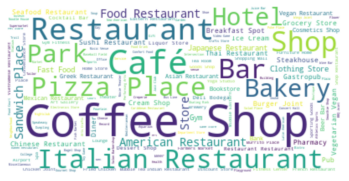

In [19]:
plt.imshow(venue_wc, interpolation = 'quadric')
plt.axis('off')
plt.show()

It seems that the most prevalent words all come from restaurant related categories, such as Coffee, Cafe, Pizza, Bakery, and so on. 

**Now lets do a onehot coding on our dataframe**

In [20]:
t_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

t_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
fixed_columns = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns]

t_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,

To make a better analysis, let's group the Neighbourhoods and calculate the mean of each category per neighbourhood.

In [21]:
toronto_grouped = t_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmon

**Lets see the top 5 venues per Neighbourhood**

In [22]:
top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2              Bar  0.04
3       Steakhouse  0.04
4  Thai Restaurant  0.03


----Agincourt----
            venue  freq
0  Breakfast Spot  0.25
1          Lounge  0.25
2  Clothing Store  0.25
3    Skating Rink  0.25
4   Metro Station  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                        venue  freq
0                  Playground  0.33
1            Asian Restaurant  0.33
2                        Park  0.33
3  Modern European Restaurant  0.00
4               Moving Target  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
                 venue  freq
0        Grocery Store   0.2
1          Pizza Place   0.1
2          Video Store   0.1
3  Fried Chicken Joint   0.1
4          Coffee Shop   0.1


----Alderwood,Long Branch----
            venue  freq
0     Pizza Place  0.25
1       

**Let's convert what we found into a dataframe**

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant
1,Agincourt,Breakfast Spot,Lounge,Skating Rink,Clothing Store,Yoga Studio
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground,Park,Asian Restaurant,Yoga Studio,Dumpling Restaurant
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pizza Place,Coffee Shop,Sandwich Place,Fast Food Restaurant
4,"Alderwood,Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pub,Sandwich Place
5,"Bathurst Manor,Downsview North,Wilson Heights",Coffee Shop,Pharmacy,Deli / Bodega,Shopping Mall,Fast Food Restaurant
6,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Dog Run
7,"Bedford Park,Lawrence Manor East",Italian Restaurant,Coffee Shop,Pharmacy,Thai Restaurant,Pizza Place
8,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Steakhouse
9,"Birch Cliff,Cliffside West",College Stadium,Café,General Entertainment,Skating Rink,Drugstore


## Let's use Kmeans to cluster the neighbourhoods

In [25]:
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [27]:
toronto_merged = toronto_merged.reset_index()

In [28]:
toronto_merged['Cluster Labels']

0      3.0
1      1.0
2      1.0
3      1.0
4      1.0
5      NaN
6      2.0
7      1.0
8      2.0
9      1.0
10     1.0
11     2.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     3.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
31     1.0
32     0.0
33     1.0
34     1.0
35     3.0
36     1.0
37     1.0
38     1.0
39     1.0
40     3.0
41     1.0
42     1.0
43     1.0
44     1.0
45     NaN
46     3.0
47     1.0
48     1.0
49     3.0
50     2.0
51     1.0
52     NaN
53     1.0
54     1.0
55     1.0
56     1.0
57     1.0
58     1.0
59     1.0
60     1.0
61     3.0
62     1.0
63     2.0
64     3.0
65     1.0
66     3.0
67     1.0
68     1.0
69     1.0
70     1.0
71     1.0
72     1.0
73     1.0
74     1.0
75     1.0
76     1.0
77     3.0
78     1.0
79     1.0
80     1.0
81     1.0
82     2.0
83     0.0
84     1.0
85     3.0
86     1.0
87     1.0
88     1.0
89     1.0
90     1.0

**There seems to be NaN values in our Cluster Labels. Let's get rid of them**

In [29]:
toronto_merged = toronto_merged.dropna()

In [30]:
toronto_merged['Cluster Labels']

0      3.0
1      1.0
2      1.0
3      1.0
4      1.0
6      2.0
7      1.0
8      2.0
9      1.0
10     1.0
11     2.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     3.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
31     1.0
32     0.0
33     1.0
34     1.0
35     3.0
36     1.0
37     1.0
38     1.0
39     1.0
40     3.0
41     1.0
42     1.0
43     1.0
44     1.0
46     3.0
47     1.0
48     1.0
49     3.0
50     2.0
51     1.0
53     1.0
54     1.0
55     1.0
56     1.0
57     1.0
58     1.0
59     1.0
60     1.0
61     3.0
62     1.0
63     2.0
64     3.0
65     1.0
66     3.0
67     1.0
68     1.0
69     1.0
70     1.0
71     1.0
72     1.0
73     1.0
74     1.0
75     1.0
76     1.0
77     3.0
78     1.0
79     1.0
80     1.0
81     1.0
82     2.0
83     0.0
84     1.0
85     3.0
86     1.0
87     1.0
88     1.0
89     1.0
90     1.0
91     3.0
92     1.0
93     1.0

**Let's change the datatype from Float to Integer**

In [31]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [32]:
toronto_merged.dtypes


index                      int64
Postcode                  object
Borough                   object
Neighbourhood             object
Latitude                 float64
Longitude                float64
Cluster Labels             int64
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
dtype: object

#### **Plotting Kmeans Cluster**

In [33]:
import folium

In [70]:
t_lat = 43.65
t_long = -79.38
map_toronto = folium.Map(location=[t_lat, t_long], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
32,M1J,-79.239476,0,Spa,Playground,Eastern European Restaurant,Dive Bar,Dog Run
83,M4T,-79.383160,0,Trail,Playground,Yoga Studio,Dive Bar,Dog Run


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,M4A,-79.315572,1,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Event Space
2,M5A,-79.360636,1,Coffee Shop,Bakery,Park,Café,Restaurant
3,M6A,-79.464763,1,Furniture / Home Store,Accessories Store,Coffee Shop,Miscellaneous Shop,Arts & Crafts Store
4,M7A,-79.389494,1,Coffee Shop,Gym,Diner,Park,College Auditorium
7,M3B,-79.352188,1,Japanese Restaurant,Gym / Fitness Center,Baseball Field,Café,Basketball Court
9,M5B,-79.378937,1,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Café
10,M6B,-79.445073,1,Pizza Place,Pub,Japanese Restaurant,Park,Sushi Restaurant
12,M1C,-79.160497,1,Bar,Golf Course,Yoga Studio,Discount Store,Dog Run
13,M3C,-79.340923,1,Asian Restaurant,Gym,Beer Store,Coffee Shop,Sporting Goods Shop
14,M4C,-79.318389,1,Beer Store,Curling Ice,Pharmacy,Park,Bus Stop


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,M1B,-79.194353,2,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Dive Bar,Dog Run
8,M4B,-79.309937,2,Pizza Place,Fast Food Restaurant,Pharmacy,Gastropub,Bank
11,M9B,-79.554724,2,Bank,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop
50,M9L,-79.565963,2,Pizza Place,Empanada Restaurant,Dumpling Restaurant,Discount Store,Dive Bar
63,M6N,-79.487262,2,Pizza Place,Convenience Store,Grocery Store,Bus Line,Eastern European Restaurant
82,M1T,-79.304302,2,Pizza Place,Thai Restaurant,Noodle House,Chinese Restaurant,Breakfast Spot


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Postcode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,-79.329656,3,Bus Stop,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant
21,M6E,-79.453512,3,Park,Women's Store,Fast Food Restaurant,Market,Convenience Store
35,M4J,-79.338106,3,Convenience Store,Park,Coffee Shop,Yoga Studio,Eastern European Restaurant
40,M3K,-79.464763,3,Airport,Construction & Landscaping,Park,Yoga Studio,Electronics Store
46,M3L,-79.506944,3,Shopping Mall,Bank,Park,Grocery Store,Yoga Studio
49,M6L,-79.490074,3,Bakery,Construction & Landscaping,Park,Basketball Court,Yoga Studio
61,M4N,-79.388790,3,Park,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant
64,M9N,-79.518188,3,Convenience Store,Park,Yoga Studio,Eastern European Restaurant,Dive Bar
66,M2P,-79.400049,3,Bank,Convenience Store,Park,Yoga Studio,Electronics Store
77,M9R,-79.554724,3,Pizza Place,Park,Bus Line,Dumpling Restaurant,Dive Bar


### Lets Try Analyzing only the Top Most Common Venue

In [39]:
num_top_venues = 1

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
top_venue = pd.DataFrame(columns=columns)
top_venue['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    top_venue.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
top_venue

,Neighbourhood,1st Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop
1,Agincourt,Breakfast Spot
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store
4,"Alderwood,Long Branch",Pizza Place
5,"Bathurst Manor,Downsview North,Wilson Heights",Coffee Shop
6,Bayview Village,Japanese Restaurant
7,"Bedford Park,Lawrence Manor East",Italian Restaurant
8,Berczy Park,Coffee Shop
9,"Birch Cliff,Cliffside West",College Stadium


**Just like above, let's analyze the frequency of each Venue Category and see if it differs**

In [40]:
top_venue_count = top_venue['1st Most Common Venue'].value_counts()
top_venue_count.head(10)

Coffee Shop               19
Pizza Place               12
Café                       5
Breakfast Spot             4
Discount Store             3
Park                       3
Indian Restaurant          2
Furniture / Home Store     2
Japanese Restaurant        2
Fast Food Restaurant       2
Name: 1st Most Common Venue, dtype: int64

**Coffee Shop still remains first place for the most common, however it's dominance has decreased a lot. Unlike the previous table, it seems Pizza Place took second place not too far off from Coffee Shop.**

### **Lets create a Wordcloud again to visualize these findings**

In [41]:
top_venue_df = top_venue['1st Most Common Venue']
top_venue_df = pd.DataFrame({'1st Most Common Venue':top_venue_df.values})
top_venue_df.head()


,1st Most Common Venue
0,Coffee Shop
1,Breakfast Spot
2,Playground
3,Grocery Store
4,Pizza Place


In [42]:
top_venue_wc = WordCloud(
    background_color='White',
    max_words=1000,
    stopwords=stopwords
)

top_venue_wc.generate(' '.join(top_venue_df['1st Most Common Venue']))

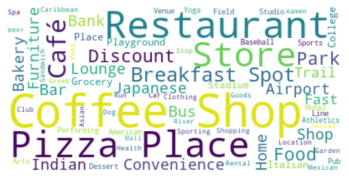

In [43]:
plt.imshow(top_venue_wc, interpolation = 'quadric')
plt.axis('off')
plt.show()

**Onehot Encoding on the new Table and Group them by their Neighbourhoods**

In [44]:
top_venue
top_onehot = pd.get_dummies(top_venue[['1st Most Common Venue']], prefix="", prefix_sep="")

top_onehot['Neighbourhood'] = top_venue['Neighbourhood']
fixed_columns = [top_onehot.columns[-1]] + list(top_onehot.columns[:-1])
top_onehot = top_onehot[fixed_columns]

top_onehot.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Bus Line,Bus Stop,Café,Caribbean Restaurant,Clothing Store,Coffee Shop,College Stadium,Convenience Store,Dessert Shop,Discount Store,Dog Run,Fast Food Restaurant,Furniture / Home Store,Garden,Greek Restaurant,Grocery Store,Health Food Store,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Lounge,Mexican Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pool,Pub,Ramen Restaurant,Rental Car Location,River,Sandwich Place,Shopping Mall,Social Club,Spa,Sporting Goods Shop,Trail,Yoga Studio
0,"Adelaide,King,Richmond",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agincourt,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Alderwood,Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
top_grouped = top_onehot.groupby('Neighbourhood').mean().reset_index()
top_grouped.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Beer Store,Breakfast Spot,Bus Line,Bus Stop,Café,Caribbean Restaurant,Clothing Store,Coffee Shop,College Stadium,Convenience Store,Dessert Shop,Discount Store,Dog Run,Fast Food Restaurant,Furniture / Home Store,Garden,Greek Restaurant,Grocery Store,Health Food Store,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Lounge,Mexican Restaurant,Park,Performing Arts Venue,Pizza Place,Playground,Pool,Pub,Ramen Restaurant,Rental Car Location,River,Sandwich Place,Shopping Mall,Social Club,Spa,Sporting Goods Shop,Trail,Yoga Studio
0,"Adelaide,King,Richmond",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agincourt,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Alderwood,Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


**Lets use K means again for the top venue**

In [46]:
kclusters = 4

top_grouped_clustering = top_grouped.drop('Neighbourhood', 1)

top_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(top_grouped_clustering)

top_kmeans.labels_[0:10]

array([1, 0, 0, 0, 2, 1, 0, 0, 1, 0], dtype=int32)

In [47]:
top_venue.insert(0, 'Cluster Labels', top_kmeans.labels_)

top_merged = toronto_df

top_merged = top_merged.join(top_venue.set_index('Neighbourhood'), on='Neighbourhood')

In [48]:
top_merged = top_merged.reset_index()

In [49]:
top_merged['Cluster Labels']

0      0.0
1      2.0
2      1.0
3      0.0
4      1.0
5      NaN
6      0.0
7      0.0
8      2.0
9      1.0
10     2.0
11     0.0
12     0.0
13     0.0
14     0.0
15     1.0
16     0.0
17     2.0
18     2.0
19     0.0
20     1.0
21     0.0
22     1.0
23     1.0
24     1.0
25     0.0
26     0.0
27     0.0
28     1.0
29     3.0
30     1.0
31     0.0
32     0.0
33     0.0
34     0.0
35     0.0
36     1.0
37     0.0
38     0.0
39     0.0
40     0.0
41     0.0
42     1.0
43     0.0
44     0.0
45     NaN
46     0.0
47     0.0
48     1.0
49     0.0
50     2.0
51     0.0
52     NaN
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     0.0
63     2.0
64     0.0
65     3.0
66     0.0
67     0.0
68     0.0
69     0.0
70     2.0
71     0.0
72     2.0
73     0.0
74     1.0
75     0.0
76     0.0
77     2.0
78     0.0
79     0.0
80     0.0
81     1.0
82     2.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0

**Again, let's drop the NaN rows and change the datatype to Integer**

In [50]:
top_merged = top_merged.dropna()
top_merged['Cluster Labels'] = top_merged['Cluster Labels'].astype(int)

In [68]:
t_lat = 43.65
t_long = -79.38
map_top = folium.Map(location=[t_lat, t_long], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(top_merged['Latitude'], top_merged['Longitude'], top_merged['Neighbourhood'], top_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=1).add_to(map_top)
    
map_top

In [62]:
top_merged.loc[top_merged['Cluster Labels'] == 0, top_merged.columns[[1] + list(range(6, top_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue
0,M3A,0,Bus Stop
3,M6A,0,Furniture / Home Store
6,M1B,0,Fast Food Restaurant
7,M3B,0,Japanese Restaurant
11,M9B,0,Bank
12,M1C,0,Bar
13,M3C,0,Asian Restaurant
14,M4C,0,Beer Store
16,M6C,0,Trail
19,M4E,0,Health Food Store


In [63]:
top_merged.loc[top_merged['Cluster Labels'] == 1, top_merged.columns[[1] + list(range(6, top_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue
2,M5A,1,Coffee Shop
4,M7A,1,Coffee Shop
9,M5B,1,Coffee Shop
15,M5C,1,Coffee Shop
20,M5E,1,Coffee Shop
22,M1G,1,Coffee Shop
23,M4G,1,Coffee Shop
24,M5G,1,Coffee Shop
28,M3H,1,Coffee Shop
30,M5H,1,Coffee Shop


In [64]:
top_merged.loc[top_merged['Cluster Labels'] == 2, top_merged.columns[[1] + list(range(6, top_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue
1,M4A,2,Pizza Place
8,M4B,2,Pizza Place
10,M6B,2,Pizza Place
17,M9C,2,Pizza Place
18,M1E,2,Pizza Place
50,M9L,2,Pizza Place
63,M6N,2,Pizza Place
70,M9P,2,Pizza Place
72,M2R,2,Pizza Place
77,M9R,2,Pizza Place


In [67]:
top_merged.loc[top_merged['Cluster Labels'] == 3, top_merged.columns[[1] + list(range(6, top_merged.shape[1]))]]

,Postcode,Cluster Labels,1st Most Common Venue
29,M4H,3,Indian Restaurant
65,M1P,3,Indian Restaurant


# Discussion

### **From the map, the colors can be defined as follows.**             
**Yellow = Cluster 0**        
**Red = Cluster 1**          
**Purple = Cluster 2**          
**Teal = Cluster 3**           

Considering I only used the top most common venue, it is not surprising that all Coffee Shops and Pizza Shops got sent to each respective cluster.       
It is important to note that this figure is based on the *Most Common Venue*. This means that even if all the Coffee Shops are centered in one area, it does not mean Coffee Shops do not exist in other areas. It simply means that Coffee Shops are most common within that specific cluster. 
However, that made the observation a lot more interesting. Lets look at the cluster containing Coffee Shops as its value (red). All the Coffee Shops being clustered in the heart of Toronto gives us an understanding that Coffee Shops in that area are popular in its availability, but there may be an abundance of Coffee Shops confined in a specific area. This means that if I were to open a store in that specific area, opening another Coffee Shops may not be the most appropriate since there will be too much competition.         
         
Now, lets examine the cluster containing the value Pizza Place (purple). It seems to be fairly scattered around Toronto, but non-existent in the heart of Toronto. This means that, while there may be still Pizza Stores in that area, it is not the most common venue. Since the Pizza Places are quite popular, it may be beneficial to open a Pizza store in the center of Toronto.        
         
Finally, let's examine the final cluster (Teal) with the value Indian Restaurant. There are two points on the map that indicate Indian Restaurant as the most common venue. Considering the venue Indian Restaurant is quite specific, we could open stores that exhibits Indian culture to compliment the Indian restaurants within those two neighborhood. 

# Conclusion

From the results, there may be an abundance of Coffee Stores at the heart of Toronto meaning opening another Coffee Store has a higher chance of failure. Further, some areas are specific to a certain ethnic culture and may benefit from opening stores that compliment that specific culture, which in our case was the Indian culture. There are many limitations to these findings. One is the use of free account for Foursquare API where I could not do an in-depth research due to the limited calls I could make. Further, my results are based on the most common venues around Toronto postal codes. I do not have data of how well each venue does in terms of revenue and profit. 